This is a working notebook exploring if SVM is a useful tool to separate shadow and floodwaters. 

In [12]:
# Import necessary packages
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
# from skimage.morphology import erosion, dilation, opening, closing, black_tophat, white_tophat
# from skimage import draw
# from skimage.morphology import disk, diamond
import rasterio as rio
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es

from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [13]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'flood-detection'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

## Try SVM on data including raw NDWI, NDVI, MSI, MBI data

In [14]:
# validation_data = pd.read_csv("validation\\Masks_testpoints.csv")
#validation_data = pd.read_csv("validation\\Index_value_testpoints.csv")
train_data = pd.read_csv("validation\\AllData_Train.csv")
test_data = pd.read_csv("validation\\AllData_Test.csv")
mask_train_data = pd.read_csv("validation\\Mask_AllData_Train.csv")
mask_test_data = = pd.read_csv("validation\\Mask_AllData_Train.csv")

In [4]:
# type(validation_data)

In [20]:
Xtest = test_data.iloc[:,[2,3,4,5,6]].values
ytest = test_data.iloc[:,1].values

In [21]:
Xtrain = train_data.iloc[:,[2,3,4,5,6]].values
ytrain = train_data.iloc[:,1].values

In [22]:
print(Xtest.shape, ytest.shape)
print(Xtrain.shape, ytrain.shape)

(232, 5) (232,)
(1026, 5) (1026,)


In [ ]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [23]:
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
accuracy_score(ytest, ypred)

0.28879310344827586

In [ ]:
# Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X, y)

In [24]:
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(Xtrain, ytrain)
ypred_rbf = clf_rbf.predict(Xtest)
accuracy_score(ytest, ypred_rbf)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.3017241379310345

[[  0 160]
 [  2  70]]


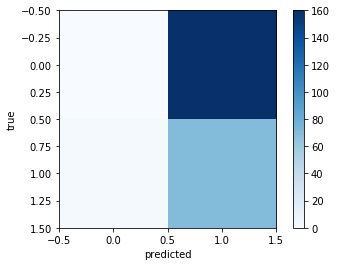

In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, ypred_rbf))

plt.imshow(confusion_matrix(ytest, ypred_rbf),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
## Tkasiry SVM on data including thresholded/masked NDWI, NDVI, MSI, MBI data

Code from PyCon 2015 Jake VanderPlas presentation 

In [ ]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

In [ ]:
# def plot_svc_decision_function(model, ax=None, plot_support=True):
#     """Plot the decision function for a 2D SVC"""
#     if ax is None:
#         ax = plt.gca()
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()
    
#     # create grid to evaluate model
#     x = np.linspace(xlim[0], xlim[1], 30)
#     y = np.linspace(ylim[0], ylim[1], 30)
#     Y, X = np.meshgrid(y, x)
#     xy = np.vstack([X.ravel(), Y.ravel()]).T
#     P = model.decision_function(xy).reshape(X.shape)
    
#     # plot decision boundary and margins
#     ax.contour(X, Y, P, colors='k',
#                levels=[-1, 0, 1], alpha=0.5,
#                linestyles=['--', '-', '--'])
    
#     # plot support vectors
#     if plot_support:
#         ax.scatter(model.support_vectors_[:, 0],
#                    model.support_vectors_[:, 1],
#                    s=300, linewidth=1, facecolors='none');
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

In [ ]:
from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

In [ ]:
clf = SVC(C=50,kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

In [ ]:
clf

In [ ]:
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None):
    estimator.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='rainbow')
    plt.clim(y.min(), y.max())

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
    plt.axis('off')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())

In [ ]:
def plot_tree_interactive(X, y):
    from sklearn.tree import DecisionTreeClassifier

    def interactive_tree(depth=1):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    from ipywidgets import interact
    return interact(interactive_tree, depth=(1, 15))

In [ ]:
plot_tree_interactive(X, y);

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0)
visualize_tree(clf, X, y, boundaries=False);